In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import QuantLib as ql

In [3]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

In [4]:
eonia = ql.Eonia()

In [5]:
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(1, ql.Days), fixingDays, ql.TARGET(), ql.Following, False, ql.Actual360()) for\
           rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]]

In [6]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor), ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia) for\
            rate, tenor in [(0.070, (1, ql.Weeks)), (0.069, (2, ql.Weeks)), (0.078, (3, ql.Weeks)), (0.074, (1, ql.Months))]]

In [7]:
helpers += [ql.DatedOISRateHelper(start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia) for\
            rate, start_date, end_date in [(0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
                                           (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
                                           (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
                                           (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
                                           (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013))]]

In [8]:
helpers += [ql.OISRateHelper(2, ql.Period(*tenor), ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia) for\
            rate, tenor in [(0.002, (15, ql.Months)), (0.008, (18, ql.Months)), (0.021, (21, ql.Months)), (0.036, (2, ql.Years)),
                            (0.0127, (3, ql.Years)), (0.274, (4, ql.Years)), (0.456, (5, ql.Years)), (0.647, (6, ql.Years)),
                            (0.827, (7, ql.Years)), (0.996, (8, ql.Years)), (1.147, (9, ql.Years)), (1.280, (10, ql.Years)),
                            (1.404, (11, ql.Years)), (1.516, (12, ql.Years)), (1.764, (15, ql.Years)), (1.939, (20, ql.Years)),
                            (2.003, (25, ql.Years)), (2.038, (30, ql.Years))]]

In [9]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J*2.0/360))) for J in [0.00102, 0.00086]]
jump_dates = [ql.Date(31, ql.December, 2012), ql.Date(31, ql.December, 2013)]

In [10]:
eonia_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed(), jumps, jump_dates)
eonia_curve.enableExtrapolation()

In [11]:
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.312/100)), ql.Period(6, ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360())]

In [12]:
euribor6m = ql.Euribor6M()

In [13]:
helpers += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), start, euribor6m) for rate, start in\
            [(0.293, 1), (0.272, 2), (0.260, 3), (0.256, 4), (0.252, 5), (0.248, 6),
             (0.254, 7), (0.261, 8), (0.267, 9), (0.279, 10), (0.291, 11), (0.303, 12),
             (0.318, 13), (0.335, 14), (0.352, 15), (0.371, 16), (0.389, 17), (0.409, 18)]]

In [14]:
discount_curve = ql.RelinkableYieldTermStructureHandle()
discount_curve.linkTo(eonia_curve)

In [15]:
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),
                              euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, tenor in \
            [(0.424, 3), (0.576, 4), (0.762, 5), (0.954, 6), (1.125, 7), (1.303, 8),
             (1.452, 9), (1.584, 10), (1.809, 12), (2.037, 15), (2.187, 20), (2.234, 25),
             (2.256, 30), (2.295, 35), (2.348, 40), (2.421, 50), (2.463, 60)]]

In [16]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

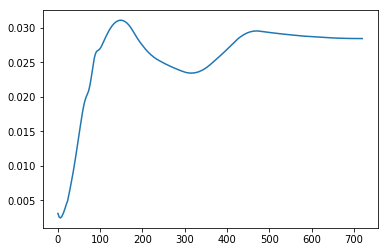

In [17]:
spot = euribor6m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 60*12+1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
_, ax = plt.subplots()
ax.plot(rates)

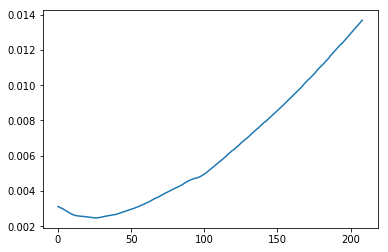

In [18]:
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*4+1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
_, ax = plt.subplots()
ax.plot(rates)

In [19]:
euribor6m_curve_0 = euribor6m_curve

In [20]:
d = ql.TARGET().advance(spot, 1, ql.Days)
F_x = euribor6m_curve_0.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()
day_counter = euribor6m.dayCounter()
T_x = day_counter.yearFraction(d, ql.TARGET().advance(d, 6, ql.Months))
alpha = (F_x - F_on)
print(alpha)

0.002949310810251873


In [21]:
synth_helpers = []
for n, units in [(1, ql.Days), (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks), (1, ql.Months), (2, ql.Months), (3, ql.Months), (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, ql.TARGET().advance(spot, n, units), ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha
    print("{0}: {1}".format(ql.Period(n, units), F))
    synth_helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)), ql.Period(n, units), 2, ql.TARGET(), ql.Following, False, ql.Actual360()))

1D: 0.0033493108102544936
1W: 0.003649310810718946
2W: 0.0036393108101770285
3W: 0.0037293108101896085
1M: 0.0036893108101338193
2M: 0.0035588914035551457
3M: 0.0034190271140937226
4M: 0.0032720330979354915
5M: 0.003187748269877364


In [22]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers+synth_helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

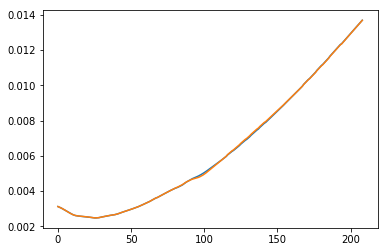

In [23]:
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*4+1)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

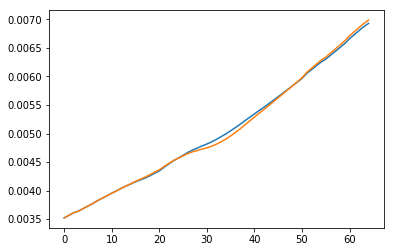

In [24]:
dates = [spot+ql.Period(i, ql.Weeks) for i in range(65, 130)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

In [28]:
start = ql.TARGET().advance(spot, 1, ql.Days)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
T_x0 = day_counter.yearFraction(start, end)
Delta0 = F_x - F_on

start = ql.TARGET().advance(spot, 1, ql.Months)
end = ql.TARGET().advance(start, 6, ql.Months)
F_x = euribor6m_curve_0.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
F_on = eonia_curve.forwardRate(start, end, ql.Actual360(), ql.Simple).rate()
T_x1 = day_counter.yearFraction(start, end)
Delta1 = F_x - F_on

t1 = day_counter.yearFraction(spot, start)
t2 = day_counter.yearFraction(spot, end)

L = np.array([[T_x0, 0.5*T_x0**2], [T_x1, 0.5*(t2**2-t2**1)]])
b = np.array([Delta0*T_x0, Delta1*T_x1])
alpga, beta = np.linalg.solve(L, b)
print(alpha)
print(beta)

0.002949310810251873
6.779472205633665e-05


In [30]:
synth_helpers = []
for n, units in [(1, ql.Days), (1, ql.Weeks), (2, ql.Weeks), (3, ql.Weeks), (1, ql.Months), (2, ql.Months), (3, ql.Months), (4, ql.Months), (5, ql.Months)]:
    t = day_counter.yearFraction(spot, ql.TARGET().advance(spot, n, units))
    F_on = eonia_curve.forwardRate(spot, ql.TARGET().advance(spot, n, units), ql.Actual360(), ql.Simple).rate()
    F = F_on + alpha + 0.5*beta*t
    print("{0}: {1}".format(ql.Period(n, units), F))
    synth_helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(F)), ql.Period(n, units), 2, ql.TARGET(), ql.Following, False, ql.Actual360()))

1D: 0.0033494049695906828
1W: 0.0036499699260722717
2W: 0.0036406290408836795
3W: 0.003731288156249585
1M: 0.003692323908891879
2M: 0.003564729282398886
3M: 0.003427501454350765
4M: 0.0032836146962867824
5M: 0.003201966329641957


In [31]:
euribor6m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers+synth_helpers, ql.Actual365Fixed())
euribor6m_curve.enableExtrapolation()

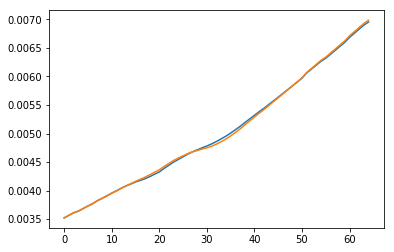

In [32]:
dates = [spot+ql.Period(i, ql.Weeks) for i in range(65, 130)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

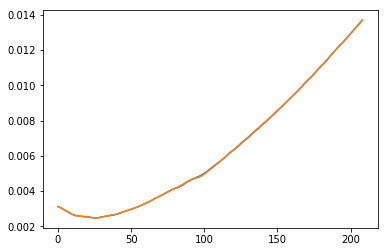

In [33]:
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*4+1)]
rates_0 = [euribor6m_curve_0.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

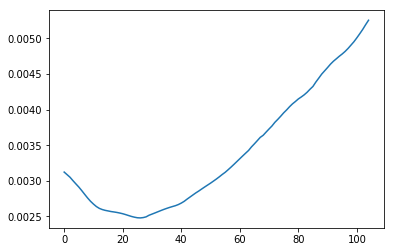

In [34]:
spot = euribor6m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*2+1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

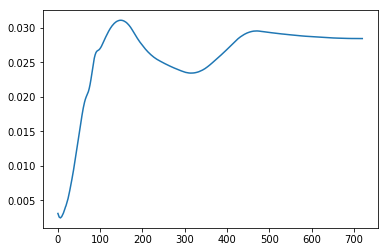

In [35]:
spot = euribor6m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 60*12+1)]
rates = [euribor6m_curve.forwardRate(d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

In [37]:
euribor12m = ql.Euribor1Y()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.54/100)), ql.Period(12, ql.Months), 2, ql.TARGET(), ql.Following, False, ql.Actual360())]
helpers += [ ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.5070/100)), 12, euribor12m)]

In [38]:
helpers += [ ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate+basis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),\
                               euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, basis, tenor in 
             [(0.424, 0.179, 3), (0.576, 0.164, 4), (0.762, 0.151, 5), (0.954, 0.139, 6), (1.135, 0.130, 7), (1.303, 0.123, 8), (1.452, 0.118, 9), (1.584, 0.113, 10),
              (1.809, 0.106, 12), (2.037, 0.093, 15), (2.187, 0.080, 20), (2.234, 0.072, 25), (2.256, 0.066, 30)]]

In [40]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(*tenor), 2, ql.TARGET(), ql.Following, False, ql.Actual360())\
                 for rate, tenor in [(0.6537, (1, ql.Months)), (0.6187, (3, ql.Months)), (0.5772, (6, ql.Months)), (0.5563, (9, ql.Months))]]

In [41]:
synth_helpers += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), months_to_start, euribor12m) for rate, months_to_start in \
                  [(0.4974, 3), (0.4783, 6), (0.4822, 9), (0.5481, 15), (0.6025, 18)]]

In [42]:
last_nasis = 0.066
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate+last_nasis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted, \
                                    ql.Thirty360(ql.Thirty360.BondBasis), euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, tenor in \
                  [(2.295, 35), (2.348, 40), (2.421, 50), (2.463, 60)]]

In [44]:
euribor12m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers+synth_helpers, ql.Actual365Fixed())
euribor12m_curve.enableExtrapolation()

In [45]:
euribor12m_curve_0 = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())
euribor12m_curve_0.enableExtrapolation()

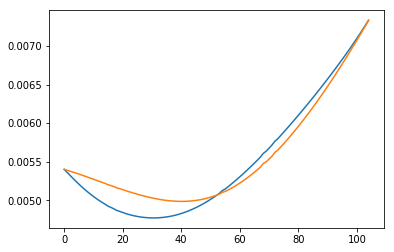

In [47]:
spot = euribor12m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*2+1)]
rates_0 = [euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

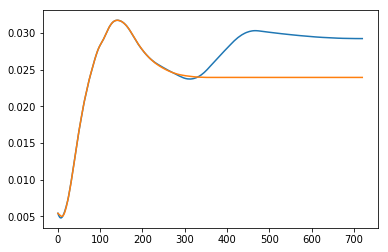

In [48]:
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 60*12+1)]
rates_0 = [euribor12m_curve_0.forwardRate(d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
rates = [euribor12m_curve.forwardRate(d, euribor12m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)
plt.plot(rates_0)

In [49]:
euribor3m = ql.Euribor3M()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.179/100)), ql.Period(3, ql.Months), 3, ql.TARGET(), ql.Following, False, ql.Actual360())]
helpers += [ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(100-rate)), start_date, euribor3m, ql.QuoteHandle()) for rate, start_date in\
            [(0.1775, ql.Date(19, ql.December, 2012)), (0.1274, ql.Date(20, ql.March, 2013)), (0.1222, ql.Date(19, ql.June, 2013)), (0.1269, ql.Date(18, ql.September, 2013)),
             (0.1565, ql.Date(18, ql.December, 2013)), (0.1961, ql.Date(19, ql.March, 2014)), (0.2556, ql.Date(18, ql.June, 2014)), (0.3101, ql.Date(17, ql.September, 2014))]]

In [50]:
helpers += [ ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),\
                               euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, basis, tenor in 
             [(0.424, 0.179, 3), (0.576, 0.164, 4), (0.762, 0.151, 5), (0.954, 0.139, 6), (1.135, 0.130, 7), (1.303, 0.123, 8), (1.452, 0.118, 9), (1.584, 0.113, 10),
              (1.809, 0.106, 12), (2.037, 0.093, 15), (2.187, 0.080, 20), (2.234, 0.072, 25), (2.256, 0.066, 30), (2.348, 0.0600, 40), (2.421, 0.0540, 50)]]

In [51]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(*tenor), 2, ql.TARGET(), ql.Following, False, ql.Actual360())\
                 for rate, tenor in [(0.1865, (2, ql.Weeks)), (0.1969, (3, ql.Weeks)), (0.1951, (1, ql.Months)), (0.1874, (2, ql.Months))]]

In [52]:
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted,\
                  ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, basis, tenor in \
                  [(2.295, 0.0650, 35), (2.463, 0.0540, 60)]]

In [53]:
futures = [(0.1775, ql.Date(19, ql.December, 2012)), (0.1274, ql.Date(20, ql.March, 2013)), (0.1222, ql.Date(19, ql.June, 2013)), (0.1269, ql.Date(18, ql.September, 2013)),
           (0.1565, ql.Date(18, ql.December, 2013)), (0.1961, ql.Date(19, ql.March, 2014)), (0.2556, ql.Date(18, ql.June, 2014)), (0.3101, ql.Date(17, ql.September, 2014))]

In [54]:
spot = euribor6m_curve.referenceDate()
day_counter = euribor3m.dayCounter()
quotes, times = zip(*[(q, day_counter.yearFraction(spot, d)) for q, d, in futures])
f = ql.MonotonicCubicNaturalSpline(times[:4]+times[5:], quotes[:4]+quotes[5:])

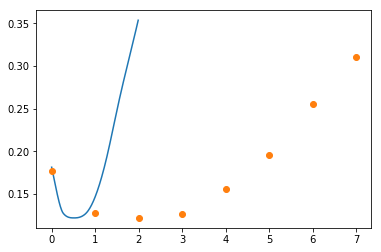

In [55]:
ts, fs = zip(*[(t, f(t, True)) for t in np.arange(0.0, 2.0, 0.01)])
plt.plot(ts, fs)
plt.plot(quotes, 'o')

In [56]:
print(quotes[4])
print(f(times[4]))

0.1565
0.15056967779056388


In [57]:
J = (quotes[4] - f(times[4])) / 100
tau = day_counter.yearFraction(ql.Date(18, ql.December, 2013), ql.Date(18, ql.March, 2014))
print(J)
print(tau)

5.930322209436123e-05
0.25


In [58]:
jumps = [ql.QuoteHandle(ql.SimpleQuote(math.exp(-J*tau)))]
jump_dates = [ql.Date(31, ql.December, 2013)]
euribor3m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers+synth_helpers, ql.Actual365Fixed(), jumps, jump_dates)
euribor6m_curve.enableExtrapolation()

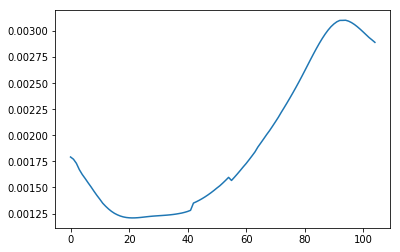

In [59]:
spot = euribor3m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*2+1)]
rates = [euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

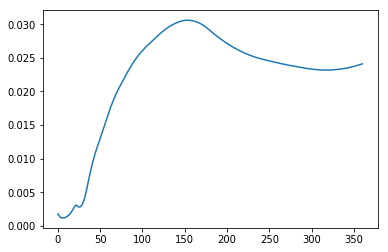

In [61]:
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 30*12+1)]
rates = [euribor3m_curve.forwardRate(d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

In [62]:
euribor1m = ql.Euribor1M()
helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(0.110/100)), ql.Period(1, ql.Months), 2, ql.TARGET(), ql.Following, False, ql.Actual360())]
helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(tenor, ql.Months), ql.TARGET(), ql.Monthly, ql.Unadjusted,\
                              ql.Thirty360(ql.Thirty360.BondBasis), euribor1m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, tenor in \
            [(0.106, 2), (0.096, 3), (0.085, 4), (0.079, 5), (0.075, 6), (0.071, 7), (0.069, 8), (0.066, 9), (0.065, 10), (0.064, 11), (0.063, 12)]]

In [63]:
helpers += [ ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-basis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted, ql.Thirty360(ql.Thirty360.BondBasis),\
                               euribor12m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, basis, tenor in 
             [(0.324, 0.226, 2), (0.424, 0.238, 3), (0.576, 0.246, 4), (0.762, 0.250, 5), (0.954, 0.250, 6), (1.135, 0.248, 7), (1.303, 0.245, 8), (1.452, 0.241, 9),
              (1.584, 0.237, 10), (1.703, 0.233, 11), (1.809, 0.228, 12), (2.037, 0.211, 15), (2.187, 0.189, 20), (2.234, 0.175, 25), (2.256, 0.163, 30)]]

In [64]:
synth_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)), ql.Period(*tenor), 2, ql.TARGET(), ql.Following, False, ql.Actual360())\
                 for rate, tenor in [(0.0661, (1, ql.Days)), (0.098, (1, ql.Weeks)), (0.0993, (2, ql.Weeks)), (0.1105, (3, ql.Weeks))]]

In [65]:
last_basis = 0.163
synth_helpers += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote((rate-last_basis)/100)), ql.Period(tenor, ql.Years), ql.TARGET(), ql.Annual, ql.Unadjusted,\
                  ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve) for rate, tenor in \
                  [(2.295, 35), (2.348, 40), (2.421, 50), (2.463, 60)]]

In [67]:
J = 0.0016
t_j = euribor1m.dayCounter().yearFraction(ql.Date(31, ql.December, 2012), ql.Date(2, ql.January, 2013))
B = 1.0/(1.0 + J*t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jump_dates = [ql.Date(31, ql.December, 2013)]

In [69]:
euribor1m_curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers+synth_helpers, ql.Actual365Fixed(), jumps, jump_dates)
euribor3m_curve.enableExtrapolation()
euribor1m_curve.enableExtrapolation()

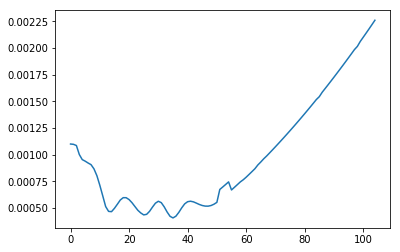

In [72]:
spot = euribor1m_curve.referenceDate()
dates = [spot+ql.Period(i, ql.Weeks) for i in range(0, 52*2+1)]
rates = [euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

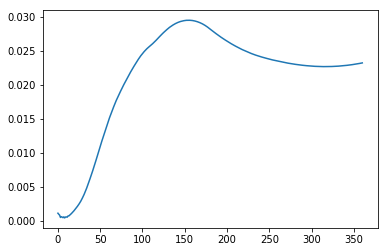

In [73]:
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 30*12+1)]
rates = [euribor1m_curve.forwardRate(d, euribor1m.maturityDate(d), ql.Actual360(), ql.Simple).rate() for d in dates]
plt.plot(rates)

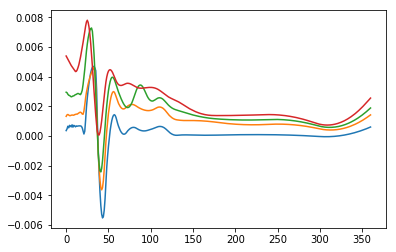

In [75]:
dates = [spot+ql.Period(i, ql.Months) for i in range(0, 12*30+1)]

def basis(curve, tenor):
    results = []
    for d in dates:
        d2 = ql.TARGET().advance(d, ql.Period(*tenor), ql.ModifiedFollowing)
        FRA1 = curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        FRA2 = eonia_curve.forwardRate(d, d2, ql.Actual360(), ql.Simple).rate()
        results.append(FRA1-FRA2)
    return results

basis_1m = basis(euribor1m_curve, (1, ql.Months))
basis_3m = basis(euribor3m_curve, (3, ql.Months))
basis_6m = basis(euribor6m_curve, (6, ql.Months))
basis_12m = basis(euribor12m_curve, (12, ql.Months))
plt.plot(basis_1m)
plt.plot(basis_3m)
plt.plot(basis_6m)
plt.plot(basis_12m)